## API Based Data Visualization

Import required packages

In [637]:
import pandas as pd
import numpy as np
import urllib.request
import json

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### Task 1. Choose one or more Web APIs

<i><b>API Chosen:</b></i>

Two APIs have been chosen for this assignment. It was provided by https://www.quandl.com/.

First API provides the information of usage, exploitation of renewable and non-renewable resources - https://www.quandl.com/data/BP-British-Petroleum.

Second API has been taken for world population over the period of time from World Bank API - https://www.quandl.com/data/WWDI-World-Bank-World-Development-Indicators

Both are open web APIs and freely available.

However, we need an API key to access them. To get the key, one must register to quandl website. The key was given to me is <i>jkCZH-uaXxXdezzBVmi6</i>

In [638]:
api_key = "jkCZH-uaXxXdezzBVmi6"

### Task 2. Collect data from chosen API

In [639]:
# Function to create csv file
def create_csv(raw_csv, heading):
    with open(raw_csv, "w") as write_file: 
        f_file = csv.writer(write_file)
        f_file.writerow(heading)
    write_file.close()

In [640]:
# Function to load data to csv file
def load_csv(api_response, raw_csv, country_name):
    
    get_page = api_response.read().decode() # Get the data from api response
    json_data = json.loads(get_page) # Since the data is json data, loading the data in json format
    
    # json data contains only two columns - date and value
    # Creating two empty list for storing date and its corresponding value separately
    date_list = []
    value_list = []
    
    num = 1000000 # For unit conversion of data
    
    # Json data is a dictionary and has a key called 'data' which actually stores the meaningful data.
    # Thus, capturing only that field.
    for data in list(json_data['dataset_data']['data']):
        
        year_data = data[0].split("-") # The 'date' data is in yearly-wise. Thus, capturing only the year from the date
        date_list.append(year_data[0]) # Appending 'date' data to date_list
        value_list.append(data[1]) # Appending corresponding "values" data to value_list
    
    # Now we have two lists - date_list with all the dates and value_list with all the values
    # Lets read the cvs file we created to store these data 
    csv_input = pd.read_csv(raw_csv)
    
    # Convert population value into millions
    if 'POP' in country_name:
        value_list[:] = [val / num for val in value_list]
    
    # Putting 'date' data to 'Date' column in CSV
    csv_input['Date'] = date_list
    
    # Putting 'values' data to new column name in CSV
    csv_input[country_name] = value_list
    
    # Write the data to csv file
    csv_input.to_csv(raw_csv, index=False)


In [641]:
# Function to call APIs, collect the data and load them to csv
def collect_data_and_load_csv(country_list, category, data_format):
    
    # Gathering codes and names of countries and categories
    country_list_names = list(country_list.values())
    country_list_codes = list(country_list.keys())
    category_names = list(category.values())
    category_codes = list(category.keys())
    
    print("Collecting Data: In Progress ... ")
    for c_code in country_list_codes:
        
        for c_cat in category_codes:
            # Two APIs have different links to get the api data. Hence, a condition to check which link to call
            # World Bank API
            if category[c_cat] == 'POP':
                # no API for population of total world
                if country_list[c_code] != 'World':
                    api_link = "https://www.quandl.com/api/v3/datasets/WWDI/" + c_code + c_cat + "/data." + data_format + "?start_date=1965-12-31&end_date=2015-12-31&api_key=" + api_key
                else:
                    break
            # British Petroleum API
            else:
                if category[c_cat] != 'OILP':
                    api_link = "https://www.quandl.com/api/v3/datasets/BP/"+ c_cat + c_code + "/data." + data_format + "?start_date=1965-12-31&end_date=2015-12-31&api_key=" + api_key
                    
                else:
                    if country_list[c_code] == 'World':
                        api_link = "https://www.quandl.com/api/v3/datasets/BP/"+ c_cat + "WRLD/data." + data_format + "?start_date=1965-12-31&end_date=2015-12-31&api_key=" + api_key
                        
                    else:
                        continue
            # Get the response
            api_response = urllib.request.urlopen(api_link)
    
            # Prepare country name column with country code and category
            # This name will be used as column name in creating a separate column in CSV
            country_name = country_list[c_code] + "-" + category[c_cat]
    
            # load csv with data only if the response is success
            if api_response.code == 200:
                load_csv(api_response, raw_csv, country_name)
            else:
                print("code: ", api_response.code)

    print("Collection Data: SUCCESS")

### Task3. Parse the collected data and store it to a file

Parsing the collected data and storing it to csv file.

In [642]:
# Creating an initial raw csv file with only one column with date
raw_csv = "raw_data.csv"
heading = ['Date']
create_csv(raw_csv, heading)

# API data to be fetched in json format
data_format = "json"

# List of countries
country_list = {
                # Top developed countries
                "USA": "USA",
                "AUS": "Australia",
                "NLD": "Netherlands",
                "JPN": "Japan",
                "GBR": "UK",
                # Top developing countries
                "IND": "India",
                "BRA": "Brazil",
                "CHN": "China",
                "SAU": "Saudi",
                "ARG": "Argentina",
                # World
                "WRLD": "World"
               }

# List of categories
category = {
            'C02_EMMISSIONS_': 'CO2', 
            'WIND_CONSUM_': 'WIN',
            'SOLAR_CONSUM_': 'SOL',
            'OIL_CONSUM_': 'OILC',
            'OIL_PROD_':'OILP',
            'HYDRO_CONSUM_': 'HYD',
            'GEO_CONSUM_': 'GEO',
            '_SP_POP_TOTL': 'POP'
            }

# Collect data and write them to intiial raw csv file
collect_data_and_load_csv(country_list, category, data_format)

Collection Data: SUCCESS


### Task 4. Load and represent the collected data as a Pandas DataFrame.

In [643]:
# Read the raw data csv file and store it to a dataframe
df_full_data = pd.read_csv("raw_data.csv")
# Sorting the year
df_full_data = df_full_data.sort_values(by=['Date'])
# Setting the Date column as index to the dataframe
df_full_data = df_full_data.set_index('Date')

In [644]:
# Sample data (last 5 rows)
df_full_data[-5:]

,USA-CO2,USA-WIN,USA-SOL,USA-OILC,USA-HYD,USA-GEO,USA-POP,Australia-CO2,Australia-WIN,Australia-SOL,...,Argentina-HYD,Argentina-GEO,Argentina-POP,World-CO2,World-WIN,World-SOL,World-OILC,World-OILP,World-HYD,World-GEO
Date,,,,,,,,,,,,,,,,,,,,,
2011,5617.270927,121.390504,4.738904,834.912754,316.095341,75.775159,311.663358,403.971405,6.432,2.044547,...,39.9780,2.167119,41.656879,32413.034874,436.540591,64.695112,4125.733448,4007.943213,3501.648542,398.555388
2012,5405.987554,142.244144,9.037014,817.005466,274.030027,77.036102,313.998379,397.164616,7.725,2.412000,...,37.3070,2.230550,42.096739,32759.662672,526.881428,100.033907,4176.184564,4116.428586,3677.295119,427.222485
2013,5544.293766,169.535096,16.039695,832.095670,266.549848,80.665532,316.204908,393.310357,9.259,3.847400,...,41.0890,2.324528,42.539925,33226.122803,644.410239,137.561154,4220.851756,4125.280826,3797.195979,458.742942
2014,5599.852215,183.490184,29.216162,838.073512,255.750580,84.070229,318.563456,398.355817,9.777,4.952000,...,41.2980,2.840839,42.981515,33342.542841,709.297772,196.332988,4254.827488,4226.230778,3886.057621,496.514926
2015,5445.018640,192.644998,39.426263,856.454458,246.453128,83.736265,320.896618,413.578708,11.802,5.958000,...,42.2609,2.150422,43.417765,33303.928537,828.035176,256.190929,4340.956744,4359.459546,3903.281964,536.410946


In [645]:
df_full_data.describe()

,USA-CO2,USA-WIN,USA-SOL,USA-OILC,USA-HYD,USA-GEO,USA-POP,Australia-CO2,Australia-WIN,Australia-SOL,...,Argentina-HYD,Argentina-GEO,Argentina-POP,World-CO2,World-WIN,World-SOL,World-OILC,World-OILP,World-HYD,World-GEO
count,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,...,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
mean,5180.338638,23.497617,2.274993,796.256273,274.469180,39.081793,254.756410,278.543663,1.308491,0.419899,...,21.953037,0.634858,32.653389,21958.181943,93.315729,16.790753,3181.611950,3197.221192,2224.732421,144.930256
std,619.491208,50.410220,7.110883,89.818844,35.062047,33.386654,38.890660,91.268516,2.852540,1.240490,...,14.847367,0.808344,6.423514,6195.766674,197.250547,49.958609,703.591042,664.214516,828.134948,145.557950
min,3631.209321,0.000000,0.000000,551.336360,198.974086,0.345000,194.303000,113.834769,0.000000,0.000000,...,1.210916,0.000000,22.283390,11357.797828,0.000000,0.000000,1525.397100,1567.894378,919.898826,5.020000
25%,4767.784891,0.000000,0.000000,747.131189,255.580387,4.088651,221.412000,210.662641,0.000000,0.000000,...,6.684342,0.073441,27.078153,18038.331703,0.001500,0.000000,2804.955848,2844.931762,1531.068383,21.595813
50%,5161.028129,2.816768,0.370795,799.738183,272.761351,57.459315,249.623000,281.487925,0.000000,0.000000,...,20.656276,0.148578,32.729739,21598.222672,3.632471,0.386563,3160.286897,3175.490352,2154.398607,116.440027
75%,5669.604313,10.879670,0.606126,853.867640,291.051688,71.560748,288.866563,357.235705,0.618800,0.060750,...,37.414500,1.098480,38.099374,25497.792392,58.185149,2.050751,3698.637893,3677.953839,2645.958439,210.724373
max,6132.419675,192.644998,39.426263,938.395230,355.973121,84.070229,320.896618,413.578708,11.802000,5.958000,...,43.831000,2.840839,43.417765,33342.542841,828.035176,256.190929,4340.956744,4359.459546,3903.281964,536.410946


<i><b><u> Missing Values </u></b></i><br>

Final Pre-Processing steps are to look for missing data to see if further pre-processing is needed.

In [646]:
# Check for any null value
df_full_data.isnull().sum() # No missing values found in the reduced dataset


USA-CO2             0
USA-WIN             0
USA-SOL             0
USA-OILC            0
USA-HYD             0
USA-GEO             0
USA-POP             0
Australia-CO2       0
Australia-WIN       0
Australia-SOL       0
Australia-OILC      0
Australia-HYD       0
Australia-GEO       0
Australia-POP       0
Netherlands-CO2     0
Netherlands-WIN     0
Netherlands-SOL     0
Netherlands-OILC    0
Netherlands-HYD     0
Netherlands-GEO     0
Netherlands-POP     0
Japan-CO2           0
Japan-WIN           0
Japan-SOL           0
Japan-OILC          0
Japan-HYD           0
Japan-GEO           0
Japan-POP           0
UK-CO2              0
UK-WIN              0
                   ..
Brazil-GEO          0
Brazil-POP          0
China-CO2           0
China-WIN           0
China-SOL           0
China-OILC          0
China-HYD           0
China-GEO           0
China-POP           0
Saudi-CO2           0
Saudi-WIN           0
Saudi-SOL           0
Saudi-OILC          0
Saudi-HYD           0
Saudi-GEO 

In [647]:
df_full_data.dtypes.value_counts() 

float64    77
dtype: int64

There's no Null's in the data, there's also no strings either, this means there's therefore no values in it such as "Not Available" or for example "No moonrise" in moonrise column, etc.<br>

Both of these are highly indicative that all values are present.

### Task 5. Analysis and Summarized the cleaned dataset

Our CSV data contains a total of 76 columns containing column names such as USA-CO2, India-WIN, etc, which shows the country and category together. For example, USA-CO2 represents Carbon Dioxide emission in USA. This way every column is unique and self-descriptive.

Since our CSV is well formated we can easily fetch specific columns and visualize their importance.

Below are the insights can be drawn from the data that we collected from APIs.

------------------------------------------------------------------------

<i><u><b>First Insight</b></u></i>:<br>
Carbon Dioxide (CO2) emission by top developed countries in last 50 years.

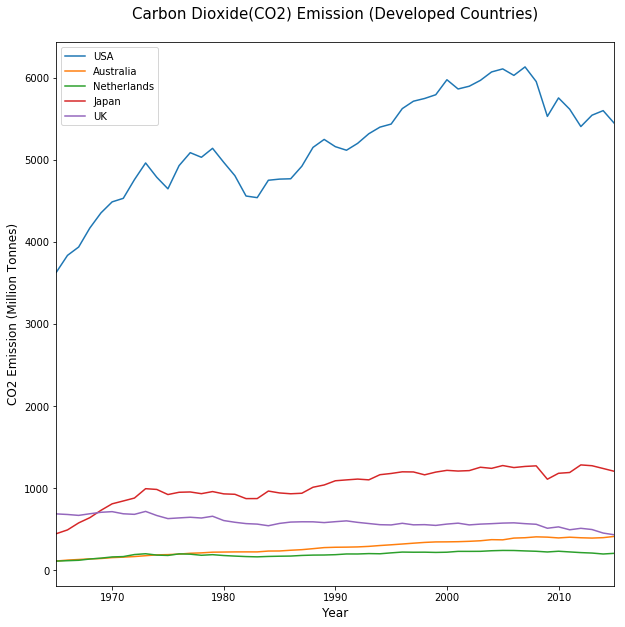

In [648]:
# Fetching the developed countries columns
df_CO2_developed_country = df_full_data[['USA-CO2', 'Australia-CO2', 'Netherlands-CO2', 'Japan-CO2', 'UK-CO2']]
# Providing a proper column names
df_CO2_developed_country.columns = ['USA', 'Australia', 'Netherlands', 'Japan', 'UK']

# Plot
plt.figure()
df_CO2_developed_country.plot(figsize=(10,10))
plt.title("Carbon Dioxide(CO2) Emission (Developed Countries)\n", fontsize=15)
plt.ylabel("CO2 Emission (Million Tonnes)", fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.show()

This plot shows that over the last 50 years how much developed countries have been emitting Carbon Dioxide gases in million tonnes. It can be seen that emission rate has been increased over the years and somewhat got controlled lately. USA, being a large country compared to other developed countries, can be seen emitting maximum CO2 gases.

----------------------------------------------------------------------------------------------------------------------------

<i><u><b>Second Insight</b></u></i>:<br>
Carbon Dioxide (CO2) emission by top developing countries in last 50 years.

We just saw CO2 emission rate for developed countries. Lets see for developing countries.

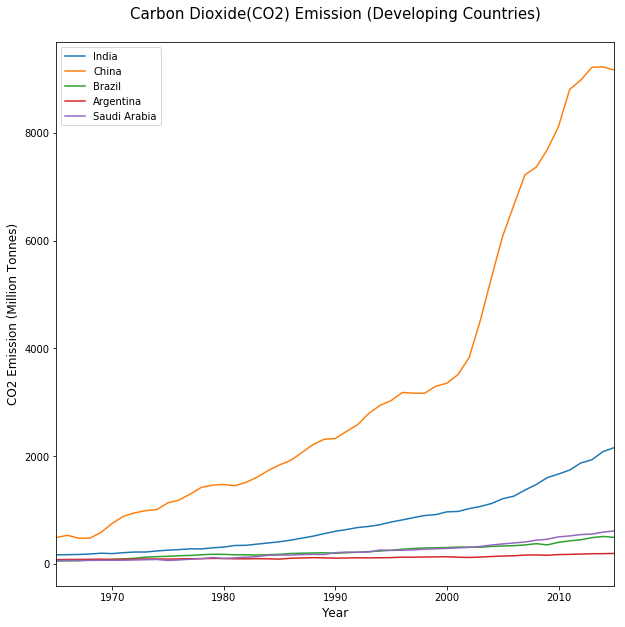

In [649]:
df_CO2_developing_country = df_full_data[['India-CO2', 'China-CO2', 'Brazil-CO2', 'Argentina-CO2', 'Saudi-CO2']]
df_CO2_developing_country.columns = ['India', 'China', 'Brazil', 'Argentina', 'Saudi Arabia']

plt.figure()
df_CO2_developing_country.plot(figsize=(10,10))
plt.title("Carbon Dioxide(CO2) Emission (Developing Countries)\n", fontsize=15)
plt.ylabel("CO2 Emission (Million Tonnes)", fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.show()

This plot shows that over the last 50 years how much developing countries have been emitting Carbon Dioxide gases in million tonnes. Like developed countries, CO2 emission rate has been increased over the years. However, emission rate for country like China has been increased exponentially in 21st century.

------------------------------------------------------------------------------------------------------------------------------

<i><u><b>Third Insight</b></u></i>:<br>
Below area plot shows the contribution of top developed and developing contribution in Total World's Carbon Dioxide(CO2) Emission year-wise

We have seen developed and developing countries separate contribution towards CO2 emission. Lets see how much they contribute in Total World's CO2 emission.

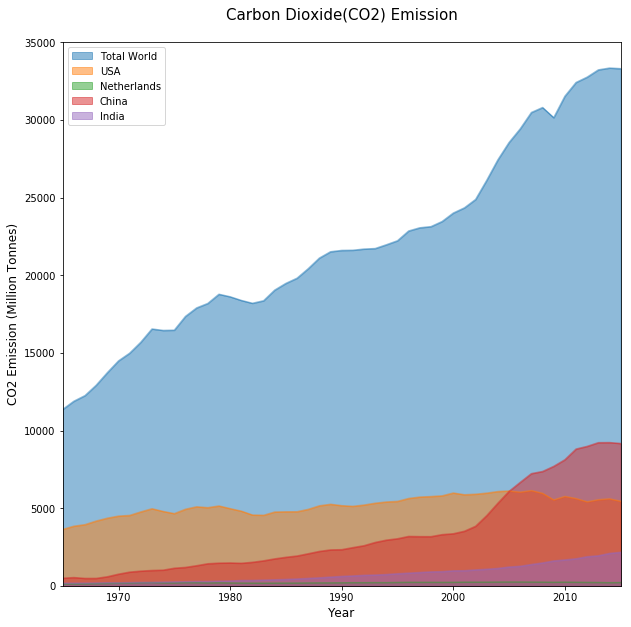

In [650]:
df_CO2_total_world = df_full_data[['World-CO2', 'USA-CO2', 'Netherlands-CO2', 'China-CO2', 'India-CO2']]
df_CO2_total_world.columns = ['Total World', 'USA', 'Netherlands', 'China', 'India']

plt.figure()
df_CO2_total_world.plot.area(stacked=False, figsize=(10,10))
plt.title("Carbon Dioxide(CO2) Emission\n", fontsize=15)
plt.ylabel("CO2 Emission (Million Tonnes)", fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.show()

We can see clearly that CO2 emission has been increased over the years and countries like China and USA contributing more than 50% of emission together

-------------------------------------------------------------------------------------------------------------------------------

<i><u><b>Fourth Insight</b></u></i>:<br>
A scatter matrix for CO2 emission and Oil Consumption in Total World.

Now we can see how much CO2 emission is affected by Oil consumption.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002081AB5E470>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000002081E0F42B0>]], dtype=object)

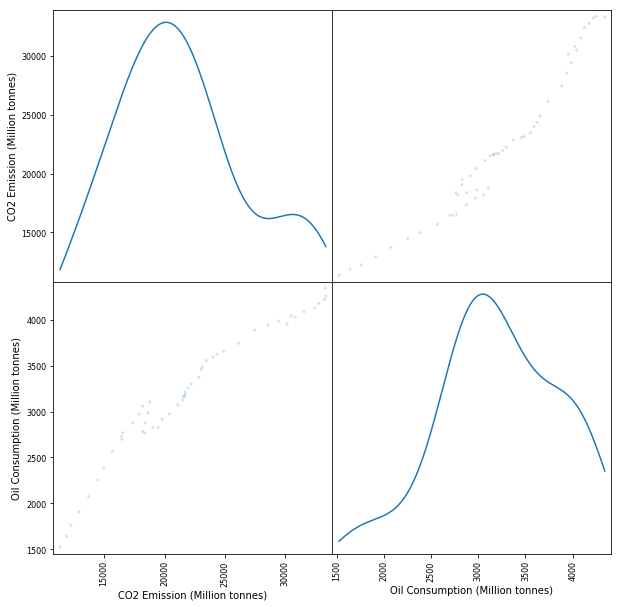

In [651]:
df_renewable = df_full_data[['World-CO2', 'World-OILC']]
df_renewable.columns = ['CO2 Emission (Million tonnes)', 'Oil Consumption (Million tonnes)']

from pandas.plotting import scatter_matrix
scatter_matrix(df_renewable, alpha=0.2, figsize=(10, 10), diagonal='kde')

This scatter matrix clearly shows that when Oil consumption is more CO2 emission is affected with huge numbers. For example, when Oil consumption around the world is around 2500 million tonnes, CO2 emission is around 15000 million tonnes and when Oil consumtion touches 4000 million tonnes, CO2 emission becomes more than twice of 15000 million tonnes.<br>
From this matrix, we can clearly state that CO2 emission is affected due to more Oil consumption.

--------------------------------------------------------------------------------------------------------------------------------

<i><u><b>Fifth Insight</b></u></i>:<br>
Renewable energy resources consumption in last 50 years.

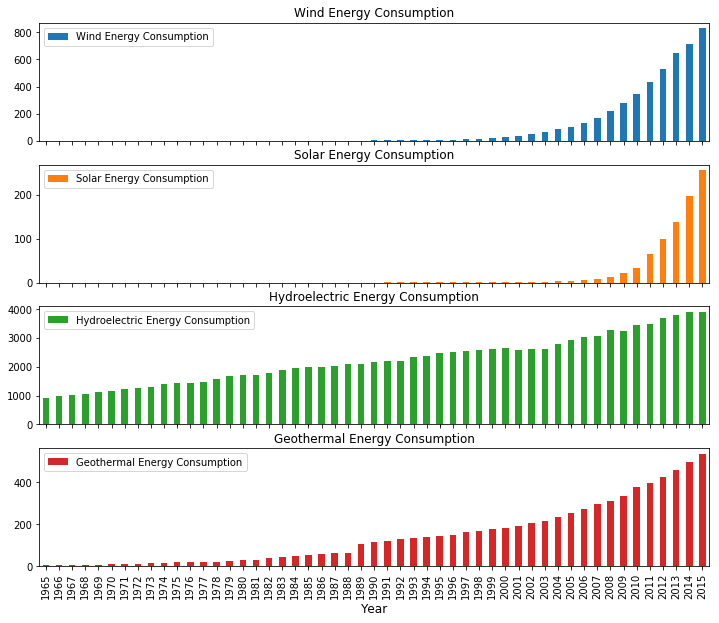

In [652]:
df_renew_energy = df_full_data[['World-WIN', 'World-SOL', 'World-HYD', 'World-GEO']]
df_renew_energy.columns = ['Wind Energy Consumption', 'Solar Energy Consumption', 'Hydroelectric Energy Consumption', 'Geothermal Energy Consumption']

plt.figure()
df_renew_energy.plot.bar(subplots=True, figsize=(12, 10));
plt.xlabel("Year", fontsize=12)
plt.show()

It's good to see that countries are investing more on renewal resources like Wind Energy and Solar Energy since the beginning of 2000s. The increasing bar graph shows tremendous increase in consumption of these renewable resources. Though Hydroelectric and Geothermal Energy consumptions have also been increased over the years.  

-------------------------------------------------------------------------------------------------------------------------------

<i><u><b>Sixth Insight</b></u></i>:<br>
Total Oil production vs Total Oil consumption

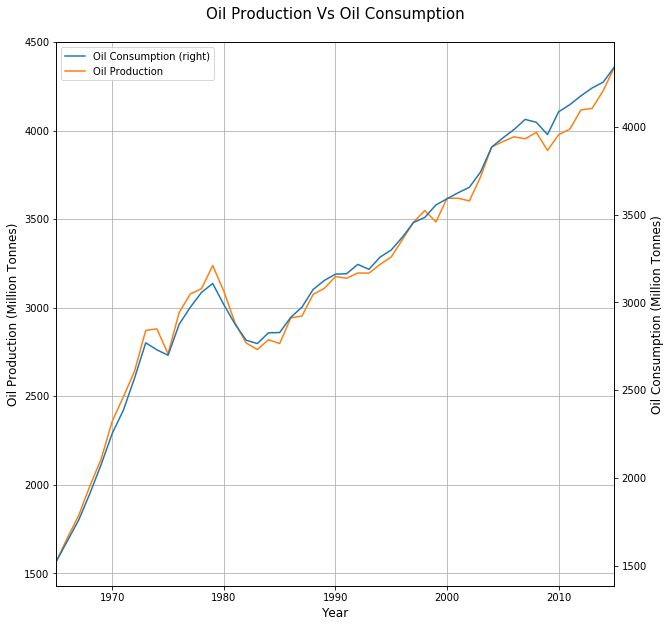

In [653]:
df_oil = df_full_data[['World-OILC', 'World-OILP']]
df_oil.columns = ['Oil Consumption', 'Oil Production']

ax = df_oil.plot(secondary_y=['Oil Consumption'], figsize=(10,10), grid=True)
ax.set_ylabel("Oil Production (Million Tonnes)", fontsize=12)
ax.right_ax.set_ylabel("Oil Consumption (Million Tonnes)", fontsize=12)
ax.set_xlabel("Year", fontsize=12)

plt.title("Oil Production Vs Oil Consumption\n", fontsize=15)

plt.show()

Above dual axis plot clearly states that the demand of Oil has been more than Oil produced in las 20 years. Oil production in entire world is struggling to keep up the demand.

--------------------------------------------------------------------------------------------------------------------------------

### Final Manipulation, Exploration and Visualisation

<i><b><u>Are developing countries polluting more than developed countries?</u></b></i>

<i>Carbon Footprint</i> - The amount of carbon dioxide released into the atmosphere as a result of the activities of a particular individual, organization, or community.

We have seen that in the first two insights that developing countries like China and India have shown a considerable amount of increment in CO2 emissions in last 20 years compared to developed countries like USA and Japan.

It is inevitable that developing countries will have more carbon footprint because of the continuos developemnt of their infrastructure. However, comparing nations can be misleading, given their vastly varied sizes and populations. To get a more meaningful picture, it's also essential to consider on CO2 Emission Per Capita basis.

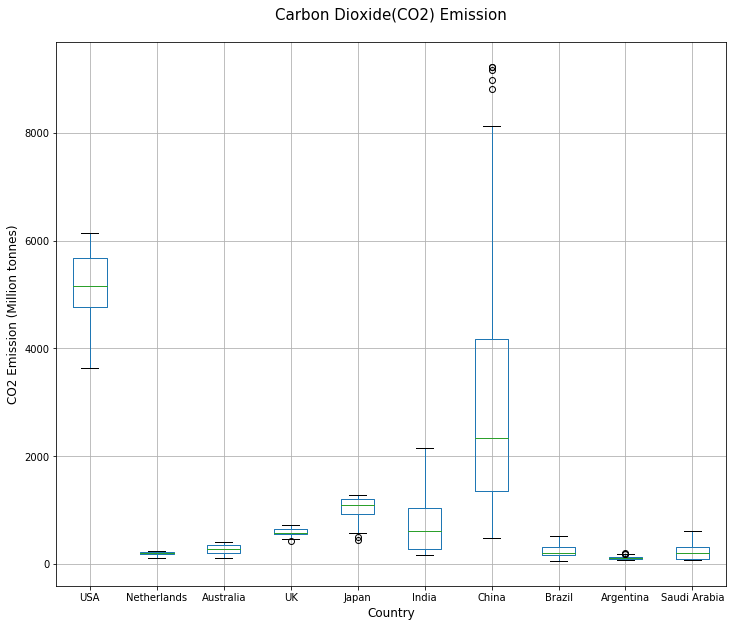

In [654]:
df_CO2_developed_country = df_full_data[['USA-CO2', 'Netherlands-CO2', 'Australia-CO2', 'UK-CO2', 'Japan-CO2', 'India-CO2', 'China-CO2', 'Brazil-CO2', 'Argentina-CO2', 'Saudi-CO2']]
df_CO2_developed_country.columns = ['USA', 'Netherlands', 'Australia', 'UK', 'Japan', 'India', 'China', 'Brazil', 'Argentina', 'Saudi Arabia']

plt.figure()

df_CO2_developed_country.plot.box(figsize=(12,10), grid=True)
plt.title("Carbon Dioxide(CO2) Emission\n", fontsize=15)
plt.ylabel("CO2 Emission (Million tonnes)", fontsize=12)
plt.xlabel("Country", fontsize=12)
plt.show()

Above box plot represents the distribution of emissions of CO2 country-wise. We can see that USA's distribution is on higher-side but China showing the highest observation with few outliers.

Since this plot only shows the amount of emission of CO2 does by a country irrespective of its size and population, we can't say that China is more polluting or have more carbon footprint than USA. 

It would be more accurate if we get the picture of CO2 emission per capita of a country. By doing that we will able to answer below questions: <br><br>
<i><b>1. Does USA need that much amount of carbon footprint considering the fact of their population?</b></i><br><br>
<i><b>2. Is China really polluting more than any other country?</b></i><br><br>
<i><b>3. And, finally we will see whether developing countries are responsible for more pollution in world.</b></i><br>

So, lets find out!

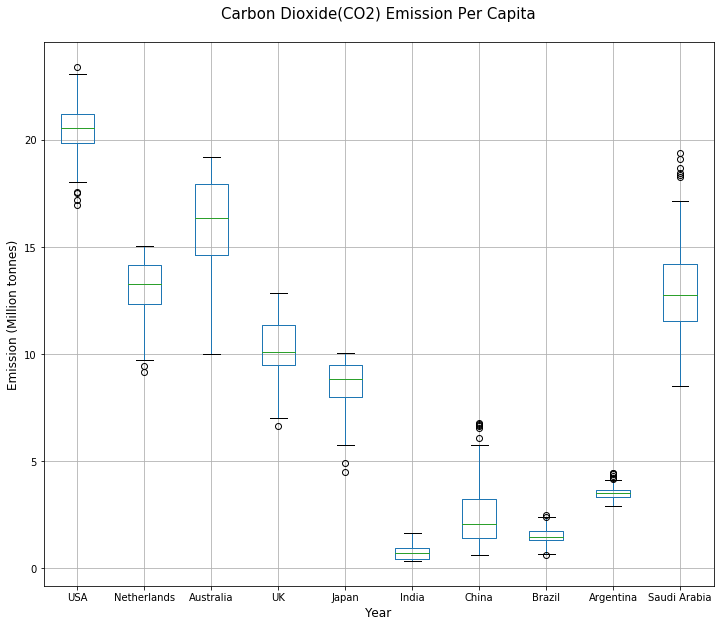

In [655]:
# Creating a new columns to represent CO2 emission per capita
# Dividing CO2 emission by total population of that country
df_pc['USA'] = df_full_data['USA-CO2']/df_full_data['USA-POP']
df_pc['Netherlands'] = df_full_data['Netherlands-CO2']/df_full_data['Netherlands-POP']
df_pc['Australia'] = df_full_data['Australia-CO2']/df_full_data['Australia-POP']
df_pc['UK'] = df_full_data['UK-CO2']/df_full_data['UK-POP']
df_pc['Japan'] = df_full_data['Japan-CO2']/df_full_data['Japan-POP']
df_pc['India'] = df_full_data['India-CO2']/df_full_data['India-POP']
df_pc['China'] = df_full_data['China-CO2']/df_full_data['China-POP']
df_pc['Brazil'] = df_full_data['Brazil-CO2']/df_full_data['Brazil-POP']
df_pc['Argentina'] = df_full_data['Argentina-CO2']/df_full_data['Argentina-POP']
df_pc['Saudi Arabia'] = df_full_data['Saudi-CO2']/df_full_data['Saudi-POP']

df_pc_new = df_pc[['USA', 'Netherlands', 'Australia', 'UK', 'Japan', 'India', 'China', 'Brazil', 'Argentina', 'Saudi Arabia']]

plt.figure()
df_pc_new.plot.box(figsize=(12,10), grid=True)
plt.title("Carbon Dioxide(CO2) Emission Per Capita\n", fontsize=15)
plt.ylabel("Emission (Million tonnes)", fontsize=12)
plt.xlabel("Year", fontsize=12)

plt.show()



Above box plot represents the distribution of emission of CO2 per individual country-wise. This plot gives the actual picture and clearly states that USA has the highest CO2 emission per capita compared to China. 

### Conclusion

Since we have seen the plot for Carbon Dioxide(CO2) emission per Capita, we can conclude the above questions now:

<i><b>1. Does USA need that much amount of carbon footprint considering the fact of their population?</b></i><br>
We know China and India are more populated countries compared to any other countries in their world. But, still we see the CO2 emission per individual is very less than the developed countries like USA, Australia and Netherlands. As a matter of fact, developed countries should be more inclined to use renewal resources rathan than using non-renewable.
<br><br>
<i><b>2. Is China really polluting more than any other country?</b></i><br>
Not at all. Considering the population of China and its size and it is still in its developing phase, CO2 emission per person is very less. On the hand, USA seems to be polluting more than any other country.
<br><br>
<i><b>3. And, finally we will see whether developing countries are responsible for more pollution in world.</b></i><br>
If we look at the last plot, all the developed countries(except Saudi Arabia) have more CO2 emission per capita compared to developing countries. So it can be concluded that <i><u>developed countries are acutally polluting more than developing countries.</u></i> As they are developed they should be looking to harness more renewable energy.
<br>